In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import scipy.io as sio
import os, pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.special import expit
import pickle 
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from IPython.display import Markdown as md
from scipy import stats
from PIL import Image
from scipy.stats import gaussian_kde
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_masked_indices(): 
    f = open("stimuli/imageFiles_1100-1.txt", "r")
    mask_morphs_indices = [i[1:-2] for i in f.read().splitlines()]
    f.close() 
    return mask_morphs_indices

In [3]:
def extract_behavioral_data(): 
    """
    example data format--converted from .mat files: 
        > experiment_data = behavioral_data[ list(behavioral_data)[2]   ]
        > experiment_data.shape
        (440, 18, 8, 9)
        
    where
    - 440 = unique stimuli
    - 18 = data containing array where 
    ---- indices 4-14 morph level coded as 1-hot vector 
    ----      i.e. [0 1 0 0 0 0 0 0 0 0 0] =  10% dog morph 
    ----      i.e. [0 0 0 0 0 0 0 0 0 0 1] = 100% dog morph 
    - 8 = sessions/days
    - 9 = monkeys    
    """
    # 
    data_path = 'behavioral_data/'#single_trial_data_2021.1.16/'
    # import names of files
    data_files = [i for i in os.listdir(data_path) if 'DS' not in i]
    # all imported files 
    behavioral_data = {i[:-4]: sio.loadmat(os.path.join(data_path,i))['raw_data'] for i in data_files}
    # formatting :/ 
    stimuli_path = 'stimuli/eLife_stim/'
    stim_folders = [i for i in os.listdir(stimuli_path) if 'Exp' in i]
    stim_files = {i: [i for i in os.listdir(os.path.join(stimuli_path, i)) if 'DS' not in i] for i in stim_folders}
    stim_files = {i: np.sort(stim_files[i]) for i in stim_files}
    mask_morph_indices = get_masked_indices()     
    
    naming = {'Exp2_central_bias': 'central_biased_morphs', 
              'Exp4_crossed_morphs': 'crossed_morphs', 
              'Exp1_linear_distribution': '10pct_spaced_morphs',
              'Exp3_masked_morphs': 'masked_morphs', 
              'central_biased_morphs': 'Exp2_central_bias',
              'crossed_morphs':'Exp4_crossed_morphs', 
              '10pct_spaced_morphs':'Exp1_linear_distribution',
              'masked_morphs':'Exp3_masked_morphs'}
    
    stim_files = {naming[i]: stim_files[i] for i in stim_files}
    
    percent_map = {
         '10pct_spaced_morphs': array([0,10,20,30,40,50,60,70,80,90,100]),
         'central_biased_morphs': array([0,25,35,40,45,50,55,60,65,75,100]),
         'masked_morphs': array([0,25,  35,  40,  45,  50,  55,  60,  65,  75, 100]),
         'crossed_morphs': array([0,10,20,30,40,50,60,70,80,90,100])}
    
    lesion_map = {0:'CON', 1:'CON', 2:'CON', 3:'TE', 4:'TE', 5:'TE', 6:'PRC', 7:'PRC', 8:'PRC'}
    
    name_map = {0:0,1:1,2:2,3:6,4:7,5:8,6:3,7:4,8:5}
    
    # initialize dataframe 
    df = pandas.DataFrame() 
    
    for e in evaluation_experiments:

        experiment = behavioral_data[ e ]

        for subject in range(experiment.shape[3]): 
        
            for day in range(experiment.shape[2]): 

                # extract all experimental data for this day
                day_data = experiment[:,:,day, subject]
                # only keep trials where there is RT data (i.e. there's a responses)--marked as 0 otherwise
                day_data = day_data[ day_data[:,1] > 0, :]

                if 'masked_morphs' in e: 
                    ids = [int(i-1) for i in day_data[:, 5]] # FIXED? 
                    image_name = [mask_morph_indices[i] for i in ids]
                    mask_FROM_IMAGE = [i[-6:-4] for i in image_name] 
                    percent = [percent_map[e][int(i-1)] for i in day_data[:, 4]] 
                    mask_FROM_MAT = day_data[:, 3]  
                    response = day_data[:, 6]
                    correct = (np.array(percent) > 50) * (response) 
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    
                else: 
                    # all indices from personal correspondence
                    ids = [int(i-1) for i in day_data[:, -1]]
                    response = day_data[:,14]
                    # extract all columns that have information related to the percent morph level
                    percent_indices = np.array([day_data[i,3:14] for i in range(day_data.shape[0])])
                    percent = np.array([percent_map[e][int(i)] for i in percent_indices.argmax(1) ])
                    image_name = [stim_files[e][i] for i in ids]
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    #ground_truth[percent==50] = np.random.randint(0,2, sum(percent==50))
 
                tiny_df = pandas.DataFrame({
                    'group': np.repeat(lesion_map[subject], day_data.shape[0]),
                    'subject': np.repeat(name_map[subject], day_data.shape[0]), 
                    'experiment': np.repeat(e, day_data.shape[0]),
                    'day': np.repeat(day, day_data.shape[0]), 
                    'trial': range(day_data.shape[0]), 
                    'percent': percent, 
                    'percent_CHECK': PERCENT_FROM_IMAGE, 
                    'image_id': ids, 
                    'image': image_name, 
                    'ground_truth': ground_truth,
                    'choice': response,    
                    'correct': ground_truth == response
                    })

                df = df.append(tiny_df, ignore_index=True)
            
    # remove all trials where images (via the stimulus ID)
    df = df[df.percent==df.percent_CHECK]
    df = df[df.group!='TE']
    
    return df[[i for i in df.columns if 'CHECK' not in i]]

In [4]:
def within_subject_splithalf_reliability(n_iterations=50): 
    
    np.random.seed(random_seed)

    def split_means(v): 
        v = np.random.permutation(v)
        return v[:len(v)//2].mean(), v[len(v)//2:].mean()

    reliability = pandas.DataFrame()

    for subject in df.subject.unique(): 

        subject_df = df[df.subject==subject]

        for e in reliability_experiments: 

            i_df = subject_df[subject_df.experiment==e]

            for i_iteration in range(n_iterations): 

                splits = [split_means(i_df[i_df.image==i].choice.values) for i in sort(i_df.image.unique())]
                both_splits = np.array(splits).T.flatten() 
                percent = [i_df[i_df.image_id==i].percent.values[0:2] for i in sort(i_df.image_id.unique())]
                splits_correct = [split_means(i_df[i_df.image==i].correct.values) for i in sort(i_df.image.unique())]
                both_correct = np.array(splits).T.flatten()

                iteration_df = pandas.DataFrame(
                    {'group': [i_df.group.values[0] for i in range(len(both_splits))],
                     'subject':  np.repeat(subject, len(both_splits)),
                     'experiment': np.repeat(e, len(both_splits)),
                     'percent': np.array(percent).T.flatten(),
                     'image': np.array([(i, i) for i in sort(i_df.image.unique())]).T.flatten() , 
                     'iteration': np.repeat(i_iteration, len(both_splits)),
                     'split':np.array([(1, 2) for i in range(len(splits))]).T.flatten() ,
                     'choice':both_splits, 
                     'correct': both_correct, 
                     'split_r': np.corrcoef(np.array(splits)[:,1], np.array(splits)[:,0])[0,1], 
                     'split_r2': r2_score(np.array(splits)[:,1], np.array(splits)[:,0]), 
                    })

                reliability = reliability.append(iteration_df, ignore_index=True)

    return reliability

In [5]:
def load_representations(representations): 
    
    print('loading ', end='')
    if representations!='pixels': 
        if representations=='resnet': 
            print('resnet representations')
            response_location = '/Users/biota/work/bonnen_and_eldridge/resnet_responses.pkl'
        elif representations=='vgg': 
            print('vgg representations')
            response_location = 'stimuli/model_responses.pkl'
        elif representations=='untrained': 
            response_location = '/Users/biota/work/bonnen_and_eldridge/untrained_responses.pkl'
        
        with open(response_location, 'rb') as f:
            representations = pickle.load(f)     
    else:         
        print('pixel representations')

        base_directory = '/Users/biota/work/bonnen_and_eldridge/eLife_stim/'
        stimulus_directories = [i for i in os.listdir(base_directory) if '.DS_Store' not in i]
        
        representations  = {} 

        for i_directory in stimulus_directories: 

            path_to_directory = os.path.join(base_directory, i_directory)
            stimulus_files = np.sort( [i for i in os.listdir(path_to_directory) if '.pcx' in i] ) 

            representations[i_directory] = {} 

            for i_file in  stimulus_files: 

                i_image = Image.open(os.path.join(path_to_directory, i_file))
                representations[i_directory][i_file] = np.array(i_image).flatten()

    
    return representations

In [6]:
n_iterations = 50

In [7]:
np.random.seed(n_iterations)
random_seed = np.random.randint(100)

In [8]:
evaluation_experiments = ['central_biased_morphs', '10pct_spaced_morphs', 'masked_morphs', 'crossed_morphs']

In [9]:
reliability_experiments = ['central_biased_morphs', '10pct_spaced_morphs'] 

In [10]:
df = extract_behavioral_data()

In [11]:
load_reliability_from_file = True

if load_reliability_from_file: 
    df_reliability = pandas.read_csv('results/within-subject_reliability_%d_iterations.csv'%n_iterations)
else: 
    # takes a while 
    df_reliability  = within_subject_splithalf_reliability(n_iterations=n_iterations)
    df_reliability.to_csv('results/within-subject_reliability_%d_iterations.csv'%n_iterations)

In [12]:
representations = load_representations('vgg') 

loading vgg representations


In [13]:
def get_reliability_matrix(rdf, resolution='subject', target='image', measure='r'): 
    
    elements = list(np.sort(rdf[resolution].unique()))
    n_elements = len(elements) 
    noise = {}
    experiment_matrices = {'target': target,'resolution':resolution} 
    
    for e in rdf.experiment.unique(): 
        
        matrix_rsq = np.zeros([n_elements,n_elements])
        matrix_pdf = np.zeros([n_elements,n_elements])
        noise[e] = {} 
        
        e_df = rdf[rdf.experiment == e]

        for s in e_df[resolution].unique(): 
            
            noise[e][s] = {} 
            s_df = e_df[e_df[resolution]==s]
            
            for q in e_df[resolution].unique(): 

                q_df = e_df[e_df[resolution]==q]
                
                if s == q: 
                    # DIAGONAL
                    if target == 'image': 
                        svec = s_df[s_df.split==1].choice.values
                        qvec = q_df[q_df.split==2].choice.values
                    elif target == 'percent': 
                        svec = s_df[s_df.split==1].groupby(['percent', 'iteration']).mean().choice.values
                        qvec = q_df[q_df.split==2].groupby(['percent', 'iteration']).mean().choice.values
                
                else: 
                    # OFF DIAGONAL
                    if target == 'image': 
                        svec = s_df.choice.values
                        qvec = q_df.choice.values
                    elif target == 'percent': 
                        svec = s_df.groupby(['percent', 'iteration']).mean().choice.values
                        qvec = q_df.groupby(['percent', 'iteration']).mean().choice.values
                
                # GET DISTRIBUTION TO ESTIMATE NOISE CEILING 
                smat = svec.reshape((svec.shape // (s_df.iteration.max()+1))[0], -1)
                qmat = qvec.reshape((qvec.shape // (s_df.iteration.max()+1))[0], -1)
                
                if measure == 'r': 
                    mu_r = np.corrcoef(svec, qvec)[0,1]    
                    pdf = [np.corrcoef(smat[:, i], qmat[:, i])[0, 1] for i in range(smat.shape[1])] 
                else: 
                    mu_r = r2_score(svec, qvec)
                    pdf = [r2_score(smat[:, i], qmat[:, i]) for i in range(smat.shape[1])] 
                
                matrix_rsq[elements.index(s),elements.index(q)] = mu_r
                noise[e][s,q] = pdf
            
        experiment_matrices[e] = matrix_rsq   
        
    experiment_matrices['noise'] = noise
    
    return experiment_matrices

In [14]:
naming = {'Exp2_central_bias': 'central_biased_morphs', 
          'Exp4_crossed_morphs': 'crossed_morphs', 
          'Exp1_linear_distribution': '10pct_spaced_morphs',
          'Exp3_masked_morphs': 'masked_morphs', 
          'central_biased_morphs': 'Exp2_central_bias',
          'crossed_morphs':'Exp4_crossed_morphs', 
          '10pct_spaced_morphs':'Exp1_linear_distribution',
          'masked_morphs':'Exp3_masked_morphs'}

In [15]:
def bound(vector, MIN=0, MAX=100, SCALE=100): 
    return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

In [112]:
def build_model1(df, n_iterations): 
    
    def make_column(x, test_df): return np.repeat(x, len(test_df))
            
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', class_weight='balanced')}

    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'ground_truth'
    model_type = 'logistic'
    noise_scale = 10 
    df_model = pandas.DataFrame()

    for i_test in evaluation_experiments:

        exp_df = df[df.experiment==i_test]
        
        # model representations
        if i_test == 'masked_morphs': 
            mask_indices = get_masked_indices()             
            X = [representations[naming[i_test]][i] for i in mask_indices] 
            
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ] 
        
        for i_iteration in range(n_iterations):
            
            random_order = np.random.permutation(range(len(X)))
            i_split = int(len(random_order)*(train_test_ratio))

            train = exp_df[ [i in random_order[:i_split] for i in exp_df.image_id.values] ] 
            test  = exp_df[ [i in random_order[i_split:] for i in exp_df.image_id.values] ] 

            train = train.groupby(analysis_level, as_index=False).mean()
            test  = test.groupby(analysis_level, as_index=False).mean()

            x_train = np.array([X[int(i-1)] for i in train.image_id.values])
            x_test  = np.array([X[int(i-1)] for i in test.image_id.values])
            
            x_train = x_train + np.random.randn(x_train.shape[0], x_train.shape[1])/noise_scale
            x_test  = x_test  + np.random.randn(x_test.shape[0] , x_test.shape[1] )/noise_scale
            
            readouts[model_type].fit(x_train, train[target].values)
            model_predictions =  readouts[model_type].predict(x_test)

            # bookkeeping
            i_df = pandas.DataFrame({
                        'group': make_column('model', test), 
                        'experiment': make_column(i_test, test),
                        'iteration': make_column(i_iteration, test), 
                        'percent': test.percent.values, 
                        'image_id': test.image_id.values, 
                        'image': test.image.values, 
                        'ground_truth': 1 * (test.percent.values >= 50),
                        'analysis_level': make_column(analysis_level, test), 
                        'target': make_column(target, test), 
                        'choice': model_predictions, 
                        'correct': np.array(model_predictions) == (1 * (test.percent.values >= 50)), 
                        'y': test[target].values
                        })

            df_model = df_model.append(i_df, ignore_index=True)
    
    return df_model

In [87]:
_x = np.array( [representations[naming[e]][i] for i in representations[naming[e]].keys() ] ) 

In [88]:
_x = _x + np.random.randn(_x.shape[0], _x.shape[1])

In [102]:
np.random.randn(_x.shape[0], _x.shape[1])/5

array([[-0.10047933, -0.19777859, -0.29291055, ..., -0.09932273,
        -0.10585124,  0.21687691],
       [ 0.45138474,  0.08755132,  0.26289265, ..., -0.22132365,
        -0.05585949,  0.00598736],
       [-0.15877058,  0.21725569, -0.46423921, ..., -0.09512729,
         0.24529115, -0.20533462],
       ...,
       [-0.03770792, -0.33194887, -0.04666621, ...,  0.00456941,
         0.4452578 ,  0.23472054],
       [ 0.29747488, -0.01844934,  0.0845929 , ..., -0.17433579,
         0.15014566, -0.09176025],
       [-0.39191518, -0.02014573, -0.15443108, ...,  0.33732685,
         0.09329975, -0.27135557]])

In [113]:
df_m1 = build_model1(df, n_iterations)

In [114]:
def show_experimental_performance(df, df_m): 
    
    colorscheme = {'CON':'#441580',
               'CON':'#7123d4',
               'PRC':'#01b282', 
               'model':'black'}

    LR = LogisticRegression(solver='lbfgs')
    iplot=1
    
    def colorFader(c1,c2,mix=0): 
        # https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
        c1=np.array(mpl.colors.to_rgb(c1))
        c2=np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    lcolors = {'PRC': colorscheme['PRC'], 
               'CON': colorscheme['CON'], 
               'model':'black'}
    
    lesion_groups = ['CON', 'PRC']
    naming = {'CON':'PRC Intact', "PRC":'PRC Lesion', }
    
    ################################# SUBJECT
    
    for e in df.experiment.unique():

        for i_group in lesion_groups: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            if iplot in [1, 5, 9, 13]: 
                plt.ylabel('Proportion Identified as Dog')
                plt.text(-.1, 1.05, ['a', 'b', 'c', 'd'][(iplot-1)//4], fontsize=12,
                         fontweight='bold', transform=ax.transAxes,)
                

            
            group_data = df[(df.group==i_group)*(df.experiment==e)]
            n_days = len(group_data.day.unique())

            for i_day in range(n_days):         

                i_color = colorFader('black',colorscheme[i_group],i_day/n_days)
                day_data = group_data[group_data.day==i_day]
                clf = LR.fit(np.expand_dims(day_data.percent,1), day_data.choice)
                X_lims = np.linspace(0, 100, 100).round(0)
                loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
                plt.plot(X_lims, loss, linewidth=1, 
                         color=i_color)

                i_behavior = day_data.groupby(['percent'], as_index=False).mean() 
                plt.scatter(x=i_behavior.percent, y=i_behavior.choice, 
                            facecolor='', s=10, linewidth=.5, edgecolor=i_color)

                plt.scatter([], [], color=i_color, label='Repeat %d'%i_day)
            
            if e == df.experiment.unique()[-1]: 
                plt.xlabel('Morph Level (% Dog)', labelpad=10)
            elif e == df.experiment.unique()[0]: 
                plt.title('%s Group Behavior'%naming[i_group], y=1.05)
                
            plt.legend(loc=4, framealpha=0, fontsize=9, title_fontsize=9, 
                       title='Experiment %d'%(((iplot-1)//4)+1))
            iplot+=1
            plt.ylim(-.05, 1.05)
        
        ####################################### MODEL PERFORMANCE ACROSS %s
        ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
                
        for i_iteration in df_m.iteration.unique(): 
            i_df = df_m[(df_m.iteration==i_iteration)&(df_m.experiment==e)]
            iteration_data = i_df.groupby(['percent'], as_index=False).mean()
            try: 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), i_df.choice.values)
            except: 
                choice_values = i_df.choice.values >= .5 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), choice_values)
            X_lims = np.linspace(0, 100, 100).round(0)
            loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
            plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=2, alpha=.1)
        
        plt.plot([], [], color=colorscheme['model'], linewidth=2, alpha=.3, label='Single')
        
        try: 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), df_m.choice.values)
        except: 
            print('!')
            choice_values = df_m.choice.values >= .5 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), choice_values)
        
        X_lims = np.linspace(0, 100, 100).round(0)
        loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
        plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=1, alpha=1, label='Average')
        plt.legend(loc=4, framealpha=0, fontsize=9, title='Experiment %d\n     Iteration'%(((iplot-1)//4)+1),
                   title_fontsize=9)
        
        if iplot ==3: 
            #plt.text(-.1, 1.05, 'c', fontsize=12, fontweight='bold', transform=ax.transAxes,)
            plt.title('VVS Model Behavior', y=1.05)
        iplot+=1
        
        
        if e == df.experiment.unique()[-1]: 
            plt.xlabel('Morph Level (% Dog)', labelpad=10)
        
        res = 'group'
        target = 'percent'
        alpha=1
        s = 40
        #################################### MODEL FIT TO GROUP BEHAVIOR 
        for group in ['CON', "PRC"]: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            igroup = df[(df[res]==group)&(df.experiment==e)]
            imodel = df_m[df_m.experiment==e].groupby(target, as_index=False)
            igroup = igroup.groupby(target, as_index=False)

            plt.scatter(x=imodel.mean().choice.values, 
                        y=igroup.mean().choice, 
                        facecolor=colorscheme[group],
                        edgecolor='black', alpha=1, s=s, 
                        linewidth=.5, label=naming[group], zorder=1)

            EB = plt.errorbar(x=imodel.mean().choice.values, 
                              y=igroup.mean().choice, 
                              xerr=(imodel.std().choice.values)/2, 
                              yerr=(igroup.std().choice.values)/2,
                              color=colorscheme[group], linestyle='', 
                              alpha=.3, 
                              elinewidth=1, 
                              zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]

           
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, zorder=-2, alpha=.3)
        plt.legend(framealpha=0, title='Model fit to group', fontsize=9, title_fontsize=9) 
        plt.xlim([-.15, 1.15])
        plt.ylim([-.15, 1.15])
        if e == df.experiment.unique()[-1]: 
            plt.xlabel('VVS Model Behavior', labelpad=10)
            
        if iplot ==4: 
            plt.title('Model Correspondence with Group Behavior', y=1.05)
        iplot+=1

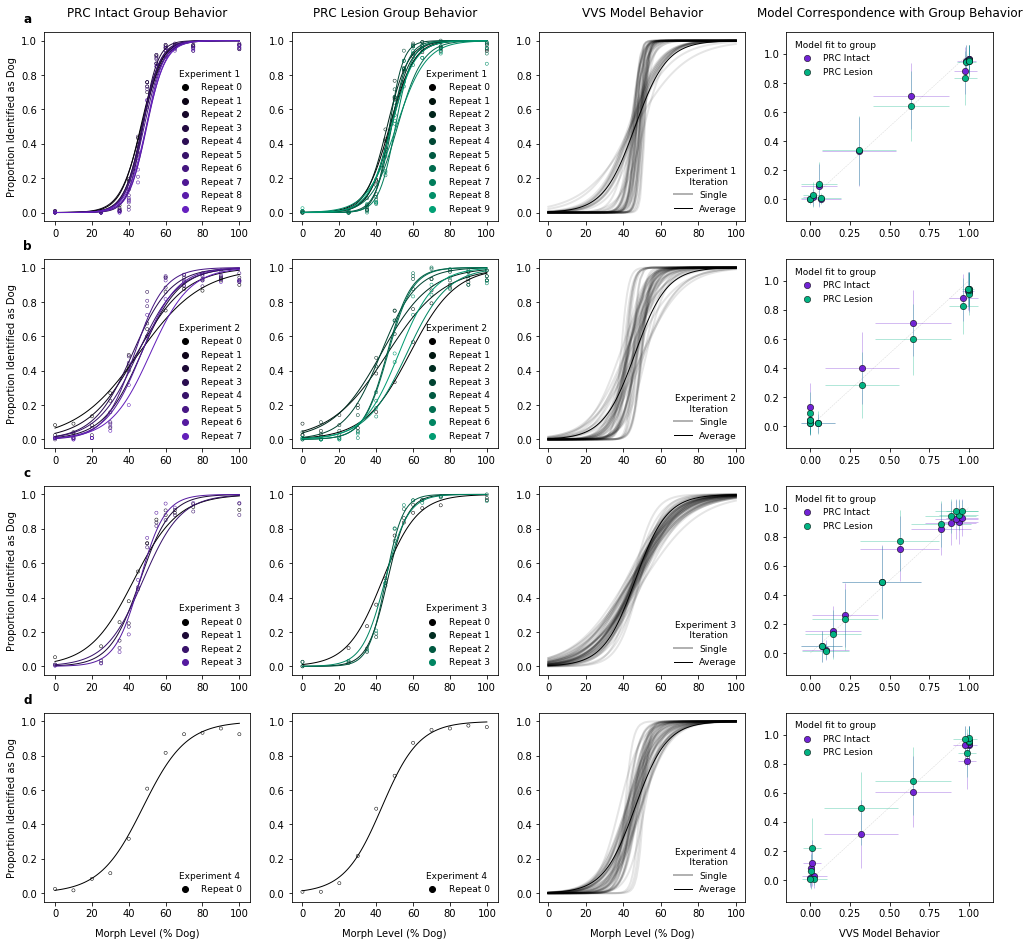

In [115]:
plt.figure(figsize=[17, 16])

show_experimental_performance(df, df_m1) 

plt.savefig('results/FIGURE1.pdf', bbox_inches = "tight", format='pdf') 

In [23]:
def show_model_parameters(m_, idx_ =-1, markdown=False):
    """prints pretty markdown stats results or latex-style formatting"""
    # fit model 
    m_ = m_.fit() 
    # extract significant figures from float 
    def sigfigs(x):
        if x>0: 
            d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
            n = np.round(float(str('%.02e'%x)[0:3]))
            return n, d
        else: 
            return x, x
    
    # extract model parameters 
    beta, pval, df_model = m_.params[idx_], m_.pvalues[idx_], m_.df_model
    rsqrd, df_resid, tvalues = m_.rsquared, m_.df_resid, m_.tvalues[idx_]
    
    sigfigs(pval)
    # show exact p values up to three significant figures 
    if sigfigs(pval)[1] < 4:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.03f $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, pval, )
    else:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.0f $ x $ 10 ^{-%d} $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, sigfigs(pval)[0], sigfigs(pval)[1])
    
    if markdown: 
        REPORT = md(report)
    else: 
        REPORT = report 
    # return markdown visualization 
    return  REPORT

In [27]:
stats.ttest_ind(
    df[df.group=='PRC'].groupby(['experiment', 'percent']).mean().choice.values, 
    df[df.group=='CON'].groupby(['experiment', 'percent']).mean().choice.values) 

Ttest_indResult(statistic=0.07381329981613718, pvalue=0.9413303595488229)

In [29]:
df_tmp = df.groupby(['experiment', 'percent'], as_index=False).mean()

df_tmp['group'] = 'primate'

tmp_m1 = df_m1.groupby(['experiment', 'percent'], as_index=False).mean() 

tmp_m1['group'] = 'model'

# df_tmp = df_tmp.append(tmp_m1, ignore_index=True)

# show_model_parameters(smf.ols('choice ~ group + percent', data=df_tmp) ,markdown=1) 

In [30]:
show_model_parameters(smf.ols('choice ~ group * percent',
    data=df.groupby(['group', 'experiment', 'percent'], as_index=False).mean() ),markdown=True) 

$R^{2} = 0.81$ $\beta = 0.00$, $F(3, 84)$ = $0.19, P = 0.851 $

In [31]:
group_behaviors = pandas.DataFrame(
    {'PRC_lesion': df.groupby(['experiment', 'percent']).mean().choice.values, 
     'PRC_intact': df.groupby(['experiment', 'percent']).mean().choice.values, 
     'model_predictions': df_m1.groupby(['experiment', 'percent']).mean().choice.values})

In [32]:
show_model_parameters( smf.ols('PRC_lesion ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.90$, $F(1, 42)$ = $46.86, P = 7 $ x $ 10 ^{-38} $

In [33]:
show_model_parameters( smf.ols('PRC_intact ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.90$, $F(1, 42)$ = $46.86, P = 7 $ x $ 10 ^{-38} $

In [34]:
group_behaviors = pandas.DataFrame(
    {'human': df.groupby(['group', 'experiment', 'percent']).mean().choice.values, 
     'group': df.groupby(['group', 'experiment', 'percent'], as_index=False).mean().group.values,
     'model_predictions': np.repeat([df_m1.groupby(['experiment', 'percent']).mean().choice.values], 2, axis=0).flatten() 
    })

show_model_parameters( smf.ols('human ~ group * model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.01$, $F(3, 84)$ = $0.38, P = 0.707 $

In [35]:
subject_behaviors = df.groupby(['group', 'subject', 'experiment', 'percent'], as_index=False).mean() 

In [36]:
show_model_parameters(smf.ols('subject1 ~ model', data={
    'subject1': subject_behaviors[subject_behaviors.subject==1].choice.values, 
    'model': df_m1.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.89$, $F(1, 42)$ = $33.98, P = 4 $ x $ 10 ^{-32} $

In [37]:
show_model_parameters(smf.ols('subject4 ~ model', data={
    'subject4': subject_behaviors[subject_behaviors.subject==4].choice.values, 
    'model': df_m1.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.92$, $F(1, 42)$ = $32.14, P = 3 $ x $ 10 ^{-31} $

In [107]:
def model_subject_correspondence(df, df_r, df_m1, resolution='subject', target='image'): 

    def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
        return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

    resolution = 'subject'
    target = 'image'
    TARGET = 'percent'
    df_r = df_reliability
    elements = list( sort(df[resolution].unique()) )
    matrix = np.zeros([len(elements), len(elements)])
    ncols = len(elements)+3
    nrows = len(elements)
    pointsize = 5
    ticksize  = 8 
    labelsize = 10
    onalpha   = .9
    offalpha  = .6
    linewidth = .5
    maxp = 101 
    minp = -1 

    LWIDTH=.5
    POINTSIZE = 40
    colorscheme = {'central_biased_morphs': {'CON':'#441580','PRC':'#128e80', 'model':'black'}, 
                   '10pct_spaced_morphs': {'CON':'#441580','PRC': '#01b282', 'model':'grey'}}

    for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

        iplot = 1         
        ae = df[(df.experiment==e)]
        aer = df_r[(df_r.experiment==e)]
        m1e = df_m1[(df_m1.experiment==e)]
        #m2e = df_m2[(df_m2.experiment==e)]

        for m in elements: 

            x = ae[ae[resolution]==m].groupby(target).mean().choice.values
            X = ae[ae[resolution]==m].groupby(TARGET).mean().choice.values

            for n in elements: 


                if m == n: 
                    nits = 2
                    maer = aer[aer[resolution]==m]
                    x = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
                    y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 

                    Y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
                    X = maer[(maer.split==1)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
                    alpha=onalpha
                else: 
                    y = ae[ae[resolution]==n].groupby([target]).mean().choice.values 
                    Y = ae[ae[resolution]==n].groupby([TARGET]).mean().choice.values 
                    alpha=offalpha

                ax = plt.subplot(nrows, ncols, iplot)
                plt.xticks([]); 
                plt.yticks([]); 

                if n == elements[0]: 
                    plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, 
                               fontsize=labelsize)
                    plt.yticks([0, 1], [0, 1], fontsize=ticksize)

                if m == elements[-1]: 
                    plt.xlabel([n, 'SUBJECT %s\nBEHAVIOR'%n][resolution=='subject'], labelpad=0,
                               fontsize=labelsize)
                    plt.xticks([0, 1], [0, 1], fontsize=ticksize)

                if (m==0)&(n==0):  
                    plt.text(-.15, 1.1, 'a', fontsize=12, transform=ax.transAxes,)


                
                if   (n in [0,1,2])&(m in [0,1,2]): color=colorscheme[e]['CON']
                elif (n in [3,4,5])&(m in [3,4,5]):color=colorscheme[e]['PRC']
                elif (n in [6,7,8])&(m in [6,7,8]): color=colorscheme[e]['TE']
                else: 
                    color='grey'
                    alpha=offalpha

                x = bound(x, MAX=max(y), SCALE=max(y))

                plt.scatter(x=x,
                            y=y, 
                            alpha=alpha, 
                            s=pointsize,
                            linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                            facecolor=[color, ''][e=='10pct_spaced_morphs'], 
                            edgecolor=['', color][e=='10pct_spaced_morphs'])

#                 plt.scatter(x=X, 
#                             y=Y, 
#                             alpha=1, 
#                             s=POINTSIZE,
#                             linewidth=LWIDTH, 
#                             facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
#                             edgecolor=['white', color][e=='10pct_spaced_morphs'])
                
                

                matrix[m, n] = r2_score(y, x)
                iplot+=1
                

            if   (m in [0,1,2]): color=colorscheme[e]['CON']
            elif (m in [3,4,5]): color=colorscheme[e]['PRC']

            iplot+=1

            #######  PERCENT
            ax = plt.subplot(nrows, ncols, iplot)
            plt.xticks([]); plt.yticks([]); 
            plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, fontsize=labelsize)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)

            
            Y_TARGET = ae[ae[resolution]==m].groupby(TARGET)
            X_MODEL = m1e.groupby([TARGET])

            plt.scatter(x=X_MODEL.mean().choice.values, 
                        y=Y_TARGET.mean().choice.values, 
                        alpha=1, 
                        s=POINTSIZE-20,
                        linewidth=LWIDTH, 
                        facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
                        edgecolor=['white', color][e=='10pct_spaced_morphs'])

            EB = plt.errorbar(
                x=X_MODEL.mean().choice.values, 
                y=Y_TARGET.mean().choice.values, 
                xerr=(X_MODEL.std().choice.values)/2, 
                yerr=(Y_TARGET.std().choice.values)/2,
                color=color, 
                linestyle='', 
                alpha=.5, 
                elinewidth=.5, 
                zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]
            plt.xticks([]); 
            plt.yticks([]);         
            if m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            if (m==0): 
                plt.text(-.15, 1.1, 'b', fontsize=12, transform=ax.transAxes,)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.3, zorder=-2)
            iplot+=1
       
            ### IMAGE LEVEL VISUALIZATION
            ax = plt.subplot(nrows, ncols, iplot)
            x_model = m1e.groupby([target]).mean().choice.values
            y_target = ae[ae[resolution]==m].groupby(target).mean().choice.values
            
            
            plt.scatter(x=x_model, y=y_target, 
                        alpha=onalpha, 
                        s=pointsize, 
                        linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                        facecolor=[color, ''][e=='10pct_spaced_morphs'], 
                        edgecolor=['', color][e=='10pct_spaced_morphs'])
            
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.3, zorder=-2)
            if (m==0): 
                plt.text(-.15, 1.1, 'c', fontsize=12, transform=ax.transAxes,)
                plt.xticks([], [])
            elif m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            else: 
                plt.xticks([], [])
            iplot+=1

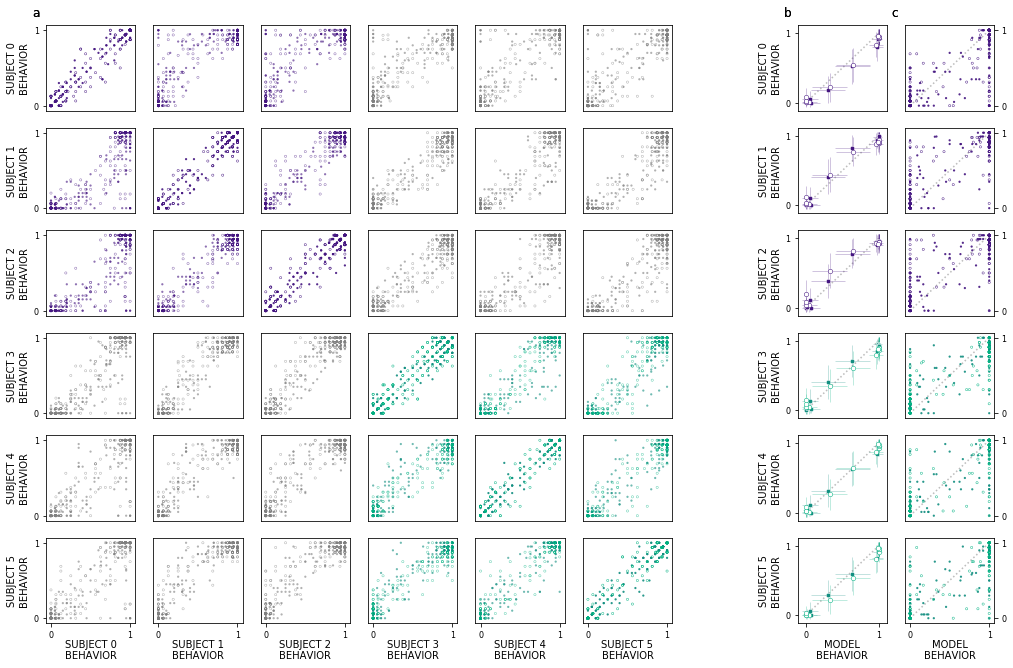

In [116]:
plt.figure(figsize=[17, 11])            
model_subject_correspondence(df, df_reliability, df_m1, resolution='subject', target='image')
plt.savefig('./results/FIGURE2_PERCENT.pdf', bbox_inches = "tight", format='pdf')

In [41]:
def show_model_parameters(m_, idx_ =-1, markdown=False):
    
    # fit model 
    m_ = m_.fit() 
    # extract significant figures from float 
    def sigfigs(x):
        if x>0: 
            d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
            n = np.round(float(str('%.02e'%x)[0:3]))
            return n, d
        else: 
            return x, x
    
    # extract model parameters 
    beta, pval, df_model = m_.params[idx_], m_.pvalues[idx_], m_.df_model
    rsqrd, df_resid, tvalues = m_.rsquared, m_.df_resid, m_.tvalues[idx_]
    
    sigfigs(pval)
    # show exact p values up to three significant figures 
    if sigfigs(pval)[1] < 4:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.03f $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, pval, )
    else:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.0f $ x $ 10 ^{-%d} $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, sigfigs(pval)[0], sigfigs(pval)[1])
    
    if markdown: 
        REPORT = md(report)
    else: 
        REPORT = report 
    # return markdown visualization 
    return  REPORT

In [117]:
distributions = {} 
np.random.seed(random_seed)
for ex in ['central_biased_morphs', '10pct_spaced_morphs']: 

    distributions[ex] = {} 
    e_df = df_reliability[df_reliability.experiment==ex]
    
    for target in ['image', 'percent']: 
            
        distributions[ex][target] = {} 
        mdata = df_m1[df_m1.experiment==ex].groupby(target).mean().choice.values

        
        for si in df.subject.unique(): 
    
            betweensubjects = {} 
            modelsubjects = [] 
            has_model_data = 0 
            
            # get reliability scores for all subject with si 
            for sj in [j for j in df.subject.unique() if j != si]: 

                ij_distribution = [] 
                
                # iterate over random split halves 
                for itrtn in df_reliability.iteration.unique(): 

                    # get reliability for iteration
                    i_it = e_df[e_df.iteration==itrtn]
                    # decide which random split to use
                    isplit = np.random.randint(2)+1
                    # subject1 data for this iteration
                    s1 = i_it[i_it.split==isplit][i_it.subject==si].groupby(target).mean().choice.values
                    # subject2 data
                    s2 = i_it[i_it.split==isplit][i_it.subject==sj].groupby(target).mean().choice.values
                    #
                    ij_distribution.append( r2_score(s2, s1) ) 
                    
                    if not has_model_data: 
                        modelsubjects.append(r2_score(s1, mdata))
                    
                has_model_data = 1
                
                betweensubjects[sj] = ij_distribution
                
            sdata = e_df[e_df.subject==si].groupby(target).mean().choice.values
        
            distributions[ex][target][si] = {'subjects':betweensubjects, 
                                            'mdistribution': modelsubjects, 
                                            'mfit': r2_score(sdata, mdata)} 

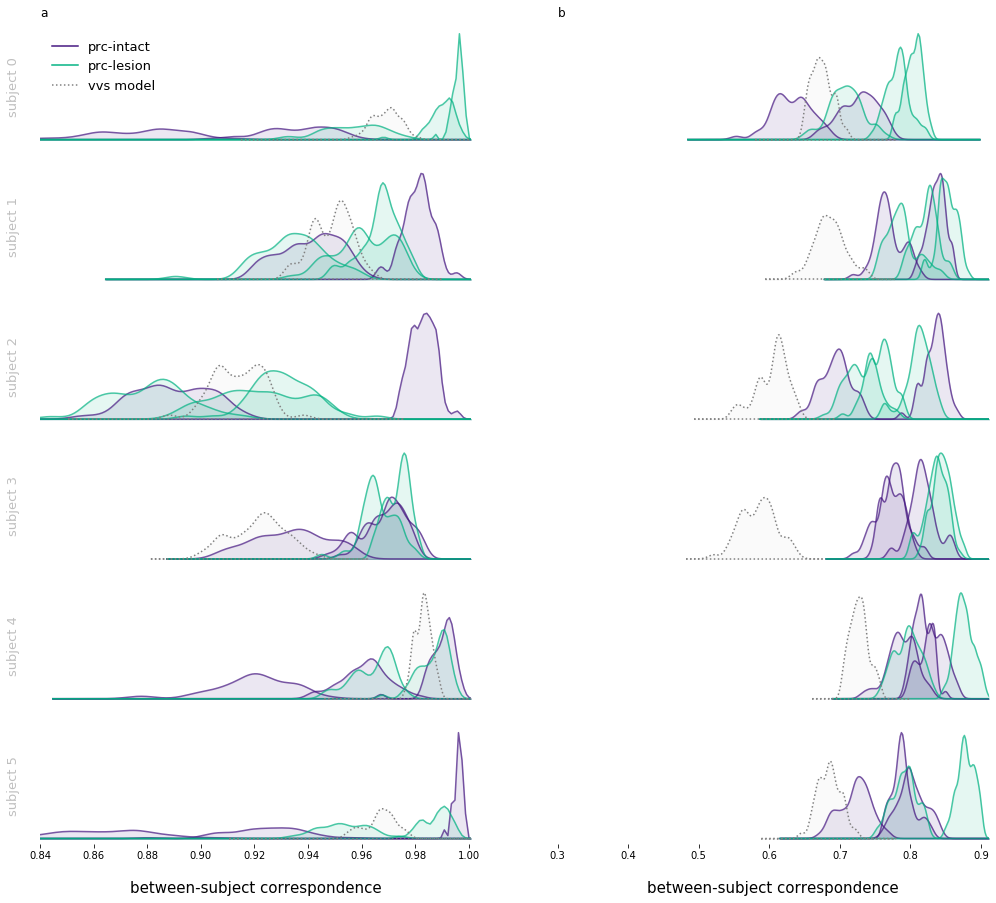

In [118]:
Cs = {'CON':'#441580', 'PRC':'#01b282', 'model':'grey'}

exps = ['10pct_spaced_morphs', 'central_biased_morphs']
target = 'percent'

exp = exps[0]
subjects = list( distributions[exp][target] )

plt.figure(figsize=[17, 15]) ; iplot=1
kernal_width = .3
for i in subjects: 

    for target in ['percent', 'image']: 
        
        sdata = distributions[exp][target][i]
        js = list(sdata['subjects'])
        others = np.array([sdata['subjects'][i] for i in js]).flatten() 
        nice_pad = (max(others) - min(others))/4
        top_point = 0

        for j in js:         

            sdata = distributions[exp][target][i]
            og_short = sdata['subjects'][j]
            density = gaussian_kde(og_short)
            xs = np.linspace(min(others)-nice_pad, max(others)+nice_pad, 200)
            density.covariance_factor = lambda : kernal_width
            density._compute_covariance()
            top_point = max( max( density(xs) ), top_point) 

            ax = plt.subplot(len(subjects), 2, iplot)
            if j in [0, 1, 2]: color = Cs['CON']
            if j in [3, 4, 5]: color = Cs['PRC']
            plt.plot(xs, density(xs), alpha=.7, color=color, )
            plt.fill_between(x=xs, y1=np.zeros(len(xs)), y2=density(xs), alpha=.1, color=color)

        mdistribution = sdata['mdistribution']
        m_density = gaussian_kde(mdistribution)
        xs = np.linspace(min(mdistribution)-nice_pad, max(mdistribution)+nice_pad, 200)
        m_density.covariance_factor = lambda : kernal_width
        m_density._compute_covariance()
        plt.plot(xs, m_density(xs), alpha=1, linestyle=':', color='grey') 
        plt.fill_between(x=xs, y1=np.zeros(len(xs)), y2=m_density(xs), alpha=.1, color='lightgrey')
        plt.plot(xs, np.zeros(len(xs)), alpha=1, linestyle=':', color='grey') 
        
        if target=='image': 
            plt.xlim(.51, .911)
            plt.xlim(.3, .911)
        else:
            plt.xlim(.84, 1.001)

        turnoff = ['right', 'left', 'top', 'bottom']
        plt.yticks([], [])
        [ax.spines[i].set_visible(False) for i in turnoff]
        if iplot<3: 
            plt.text(0, 1.1, ['a', 'b'][target=='image'], fontsize=12, transform=ax.transAxes,)
        if iplot<11: 
            plt.xticks([],[]) 
        if iplot==1: 
            plt.plot([], [], alpha=1, color=Cs['CON'], label='prc-intact')
            plt.plot([], [], alpha=1, color=Cs['PRC'], label='prc-lesion')
            plt.plot([], [], alpha=1, color='grey', label='vvs model', linestyle=':') 
            plt.legend(loc=2, framealpha=0, fontsize=13)
        if (iplot==11)|(iplot==12): 

            plt.xlabel('between-subject correspondence', labelpad=20, fontsize=15)
        if iplot%2: 
            ax.spines['left'].set_visible(False)
            plt.ylabel('subject %d'%i, labelpad=20, color='grey', #color=Cs[['PRC', 'CON'][i in [0,1,2]]], 
                       alpha=.5, fontsize=13)
        iplot+=1

plt.savefig('./results/distributions.pdf', bbox_inches = "tight", format='pdf')

In [55]:
pMgD = []
target = 'percent'
for s in subjects: 
    for e in exps: 
        idata = distributions[e][target][s]
        idistribution = np.array([idata['subjects'][i] for i in idata['subjects']]).flatten() 
        pMgD.append( np.mean( idistribution >= np.median( sdata['mdistribution'] ) ) ) 

In [61]:
pMgD

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [98]:
! open ./results

$R^{2} = 0.86$ $\beta = 0.81$, $F(1, 30)$ = $13.33, P = 4 $ x $ 10 ^{-14} $

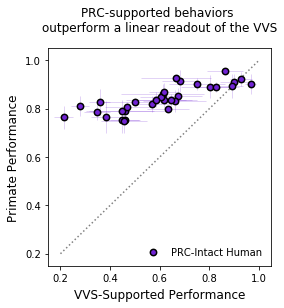

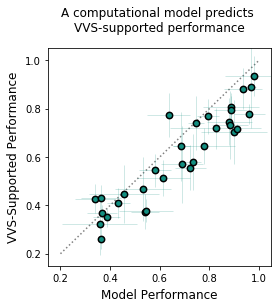

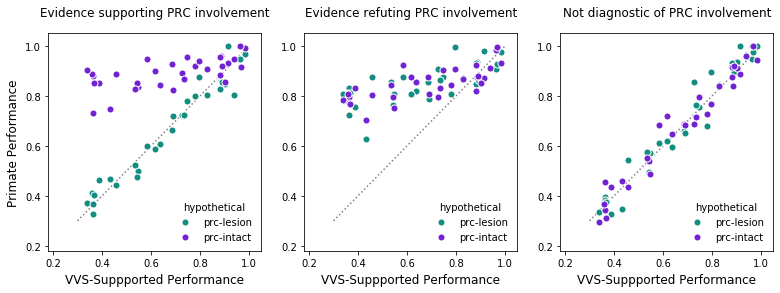

In [63]:
hvm_path = '~/work/mtl_perception/high-throughput/human_performance.csv'
hvm = pandas.read_csv(hvm_path)

hvm_path = '/Users/biota/work/mtl_perception/high-throughput/summary_dataframe.csv'
hvm_summary = pandas.read_csv(hvm_path)


def scatter_with_bar(x, y, xerr, yerr, c, l='', d='observed'):     
    plt.scatter(x=x, y=y, facecolor=c, edgecolor='black', s=40, linewidth=lwidth, label=l)
    ltype = '-'
    elinewidth=1
    alpha=.2
    EB = plt.errorbar(x=x, y=y, 
                      xerr=xerr, 
                      yerr=yerr,
                      color=c, 
                      linestyle='', alpha=alpha, 
                      elinewidth=elinewidth, 
                      zorder=-1, ) 
    [EB[-1][i].set_linestyle(ltype) for i in [0, 1]]


cscheme = {'CON':'#7123d4', 'PRC':'#128e80', 'model':'black'}
cscheme = {'CON':'#7123d4', 'PRC':'#128e80', 'model':'black'}
xy = hvm.groupby('typical_name')
group = 'CON'
hshape = 'o'
hsize = 50
lwidth = 1.5
ecolor = 'black'


plt.figure(figsize=[4, 4])
plt.subplot(111)
xy = hvm.groupby('oddity_name')


scatter_with_bar(xy.mean().it.values, xy.mean().human.values, 
                 xy.std().it.values/2, xy.std().human.values/2,
                 cscheme['CON'], l='PRC-Intact Human')

plt.ylabel('Primate Performance', fontsize=12, labelpad=5)

plt.yticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]); 
plt.xticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]);
plt.plot([.2, 1], [.2, 1], linestyle=':', color='grey', zorder=-2)
plt.ylim([.15, 1.05])
plt.xlim([.15, 1.05])
plt.xlabel('VVS-Supported Performance', fontsize=12, labelpad=5)
plt.title('PRC-supported behaviors \noutperform a linear readout of the VVS', y=1.05);
plt.legend(loc=4, framealpha=0)

plt.savefig('results/SCHEMATIC0.pdf', bbox_inches = "tight", format='pdf') 

plt.figure(figsize=[4, 4])
plt.subplot(111)
xy = hvm.groupby('oddity_name')


scatter_with_bar(hvm_summary.fc6, hvm_summary.it, 
                 xy.std().fc6.values/2, xy.std().it.values/2,
                 cscheme['PRC'])
plt.ylim([.18, 1.05])
plt.xlim([.18, 1.05])

plt.xlabel('Model Performance', fontsize=12, labelpad=5)
plt.ylabel('VVS-Supported Performance', fontsize=12, labelpad=5)
plt.yticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]); 
plt.xticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]);
plt.plot([.2, 1], [.2, 1], linestyle=':', color='grey', zorder=-2, label='IT Readout')
plt.ylim([.15, 1.05])
plt.xlim([.15, 1.05])
plt.title('A computational model predicts \nVVS-supported performance', y=1.05);

plt.savefig('results/SCHEMATIC1.pdf', bbox_inches = "tight", format='pdf') 

def scatter_with_bar(x, y, xerr, yerr, c, d='synthetic', l=''):     
    if d=='synthetic': 
        plt.scatter(x=x, y=y, edgecolor='white', facecolor=c, s=hsize, alpha=1, label=l)
    else: 
        plt.scatter(x=x, y=y, facecolor=c, edgecolor='black', s=40, linewidth=lwidth)
        ltype = '-'
        elinewidth=1
        alpha=.3

def set_axes(): 
    plt.yticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]); 
    plt.xticks([.2, .4, .6, .8, 1.], [.2, .4, .6, .8, 1.]);
    plt.plot([.3, 1], [.3, 1], linestyle=':', color='grey', zorder=-2, label='IT Readout')
    plt.ylim([.18, 1.05])
    plt.xlim([.18, 1.05])
    

cscheme = {'CON':'#7123d4', 'PRC':'#128e80', 'model':'black'}
xy = hvm.groupby('typical_name')
group = 'CON'
hshape = 'o'
hsize = 50
lwidth = 1.5
ecolor = 'black'
itype = 'fc6'

plt.figure(figsize=[13, 4])

ax = plt.subplot(131)
plt.ylabel('Primate Performance', fontsize=12, labelpad=5)
plt.xlabel('VVS-Suppported Performance', fontsize=12, labelpad=5)
np.random.seed(11)
ratio = 20
fake_prc_lesion = [np.min([i, 1]) for i in (xy.mean().fc6+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_lesion, xy.std()[itype], xy.std().human, cscheme['PRC'])
ratio = 30
fake_prc_intact = [np.min([i+.05, 1]) for i in (xy.mean().human+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_intact, xy.std()[itype], xy.std().human, cscheme['CON'])

plt.title('Evidence supporting PRC involvement', y=1.05)
#plt.text(-.1, 1.02, 'b', fontsize=12, fontweight='bold', transform=ax.transAxes,)
plt.scatter([], [], facecolor=cscheme['PRC'], edgecolor='white', s=50, linewidth=1, label='prc-lesion')
plt.scatter(x=[], y=[],  facecolor=cscheme['CON'], edgecolor='white', s=50, linewidth=1, label='prc-intact')
plt.legend(framealpha=0, loc=4, title='hypothetical')
set_axes() 


ax = plt.subplot(132)

np.random.seed(101)
ratio = 30
fake_prc_lesion = [np.min([i, 1]) for i in (xy.mean().human+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_lesion, xy.std()[itype], xy.std().human, cscheme['PRC'])
fake_prc_intact = [np.min([i, 1]) for i in (xy.mean().human+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_intact, xy.std()[itype], xy.std().human, cscheme['CON'])
plt.xlabel('VVS-Suppported Performance', fontsize=12, labelpad=5)
plt.title('Evidence refuting PRC involvement', y=1.05);
plt.scatter([], [], facecolor=cscheme['PRC'], edgecolor='white', s=50, linewidth=1, label='prc-lesion')
plt.scatter(x=[], y=[],  facecolor=cscheme['CON'], edgecolor='white', s=50, linewidth=1, label='prc-intact')
plt.legend(framealpha=0, loc=4, title='hypothetical')
set_axes() 

ax = plt.subplot(133)
#plt.text(-.1, 1.02, 'a', fontsize=12, fontweight='bold', transform=ax.transAxes,)
np.random.seed(101)
ratio = 20
fake_prc_lesion = [np.min([i, 1]) for i in (xy.mean()[itype]+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_lesion, xy.std()[itype], xy.std().human, cscheme['PRC'], 'synthetic')
fake_prc_intact = [np.min([i, 1]) for i in (xy.mean()[itype]+(np.random.randn(len(xy))/ratio))]
scatter_with_bar(xy.mean()[itype], fake_prc_intact, xy.std()[itype], xy.std().human, cscheme['CON'], 'synthetic')

plt.title('Not diagnostic of PRC involvement', y=1.05)
plt.xlabel('VVS-Suppported Performance', fontsize=12, labelpad=5)
plt.scatter([], [], facecolor=cscheme['PRC'], edgecolor='white', s=50, linewidth=1, label='prc-lesion')
plt.scatter(x=[], y=[],  facecolor=cscheme['CON'], edgecolor='white', s=50, linewidth=1, label='prc-intact')
plt.legend(framealpha=0, loc=4, title='hypothetical')
set_axes() 
plt.savefig('results/SCHEMATIC2.pdf', bbox_inches = "tight", format='pdf') 

np.corrcoef( hvm_summary.fc6, hvm_summary.it)[0, 1]

show_model_parameters(smf.ols('neural ~ model',
                              data={'neural': hvm_summary.it, 'model':hvm_summary.fc6}),markdown=True)

In [28]:
! open ./results

In [119]:
def build_conservative_model(df, n_iterations, conservative=1): 

    def get_image_identity(i): 
        return i[i.find('img')+3:i.find('img')+6]
    
    def make_column(x, test_df): return np.repeat(x, len(test_df))
                
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', max_iter=2000)}
    
    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'ground_truth'
    model_type = 'logistic'
    mask_indices = get_masked_indices()   
    df_model = pandas.DataFrame()

    for i_test in df.experiment.unique():
            
        print( i_test )
        
        e_df = df[df.experiment==i_test]

        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]
        
        e_df['L'] = np.array([get_image_identity(i) for i in list( e_df.image.values )]) 
        
        
        for i_iteration in range(n_iterations):
            
            if not conservative: 
                random_order = np.random.permutation(range(len(X)))
                i_split = int(len(random_order)*(train_test_ratio))
                
                train = e_df[ [i in random_order[:i_split] for i in e_df.image_id.values] ] 
                test  = e_df[ [i in random_order[i_split:] for i in e_df.image_id.values] ] 
            
            else: 
                
                labels = np.unique(e_df['L']) 
                
                random_order = np.random.permutation(labels)
                i_split = int(len(random_order)*(train_test_ratio))
            
                train = e_df[ [i in random_order[:i_split] for i in e_df.L.values] ] 
                test  = e_df[ [i in random_order[i_split:] for i in e_df.L.values] ] 
                
                train = train.groupby(analysis_level, as_index=False).mean()
                test  = test.groupby(analysis_level, as_index=False).mean()

                x_train = [X[int(i-1)] for i in train.image_id.values ]
                x_test  = [X[int(i-1)] for i in test.image_id.values ]
                
                readouts[model_type].fit(x_train, train[target].values)
                model_predictions =  readouts[model_type].predict(x_test)

                # bookkeeping
                i_df = pandas.DataFrame({
                            'group': make_column('model', test), 
                           # 'subject': make_column(i_subject, test), 
                            'experiment': make_column(i_test, test),
                            'iteration': make_column(i_iteration, test), 
                            'percent': test.percent.values, 
                            'image_id': test.image_id.values, 
                            'image': test.image.values, 
                            'ground_truth': 1 * (test.percent.values >= 50),
                            'analysis_level': make_column(analysis_level, test), 
                            'target': make_column(target, test), 
                            'choice': model_predictions, 
                            'correct': (np.array(model_predictions)>=.5) == (1*(test.percent.values >= 50)), 
                            'y': test[target].values
                            })

                df_model = df_model.append(i_df, ignore_index=True)

    return df_model

def build_conservative_model2(df, n_iterations, conservative=1): 

    def get_image_identity(i): 
        return i[i.find('img')+3:i.find('img')+6]
    
    def make_column(x, test_df): return np.repeat(x, len(test_df))
                
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', max_iter=2000)}
    
    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'choice'
    model_type = 'linear'
    mask_indices = get_masked_indices()   
    df_model = pandas.DataFrame()

    for i_test in df.experiment.unique():
            
        e_df = df[df.experiment==i_test]

        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]
        
        e_df['L'] = np.array([get_image_identity(i) for i in list( e_df.image.values )]) 
        
        for i_subject in e_df.subject.unique(): 
            
            s_df = e_df[e_df.subject==i_subject]
            labels = np.unique(s_df['L']) 
            
            for i_iteration in range(n_iterations):

                random_order = np.random.permutation(labels)
                i_split = int(len(random_order)*(train_test_ratio))
                
                train = s_df[ [i in random_order[:i_split] for i in s_df.L.values] ] 
                test  = s_df[ [i in random_order[i_split:] for i in s_df.L.values] ] 
                train = train.groupby(analysis_level, as_index=False).mean()
                test  = test.groupby(analysis_level, as_index=False).mean()
                
                x_train = [X[int(i-1)] for i in train.image_id.values ]
                x_test  = [X[int(i-1)] for i in test.image_id.values ]

                readouts[model_type].fit(x_train, train[target].values)
                model_predictions =  readouts[model_type].predict(x_test)

                # bookkeeping
                i_df = pandas.DataFrame({
                            'group': make_column('model', test), 
                            'subject': make_column(i_subject, test), 
                            'experiment': make_column(i_test, test),
                            'iteration': make_column(i_iteration, test), 
                            'percent': test.percent.values, 
                            'image_id': test.image_id.values, 
                            'image': test.image.values, 
                            'ground_truth': 1 * (test.percent.values >= 50),
                            'analysis_level': make_column(analysis_level, test), 
                            'target': make_column(target, test), 
                            'choice': model_predictions, 
                            'correct': (np.array(model_predictions)>=.5) == (1*(test.percent.values >= 50)), 
                            'y': test[target].values
                            })

                df_model = df_model.append(i_df, ignore_index=True)

    return df_model

In [120]:
df_c1 = build_conservative_model(df, n_iterations)

central_biased_morphs
10pct_spaced_morphs
masked_morphs
crossed_morphs


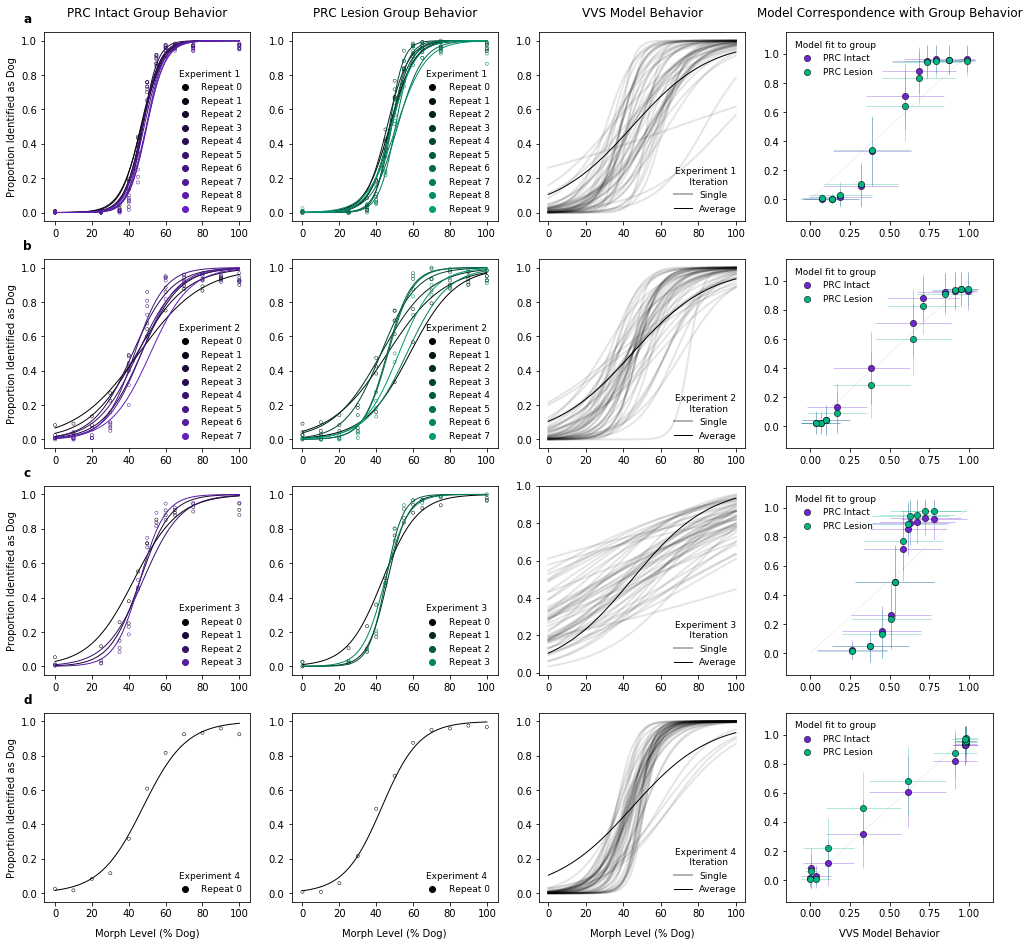

In [121]:
plt.figure(figsize=[17, 16])
show_experimental_performance(df, df_c1) 
plt.savefig('results/FIGURE1_CONSERVATIVE.pdf', bbox_inches = "tight", format='pdf') 

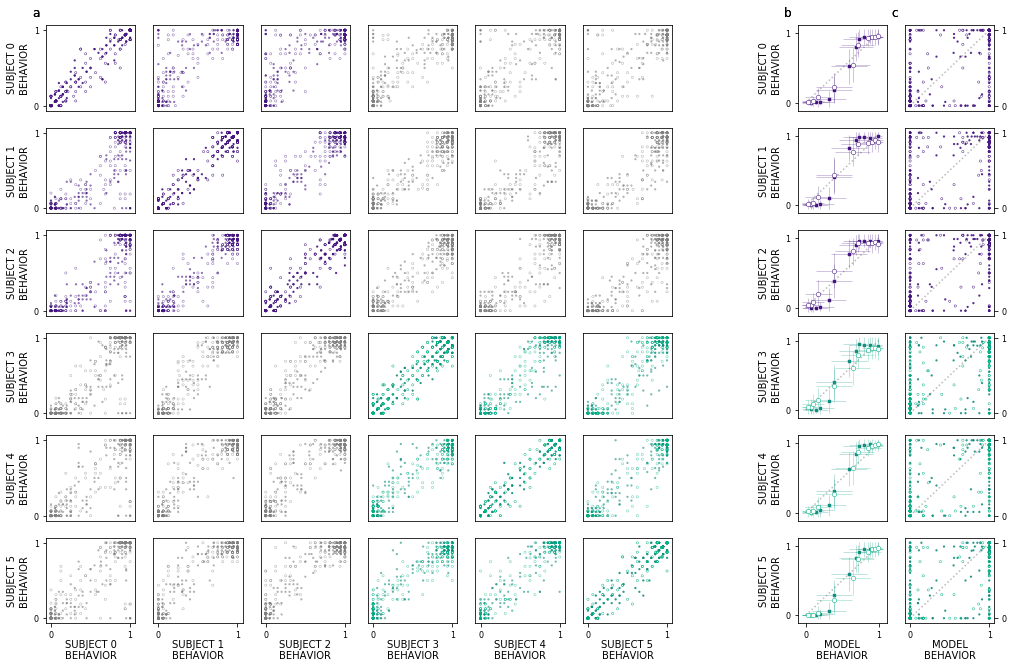

In [122]:
plt.figure(figsize=[17, 11])      
model_subject_correspondence(df, df_reliability, df_c1, resolution='subject', target='image')
plt.savefig('./results/FIGURE2_CONSERVATIVE.pdf', bbox_inches = "tight", format='pdf')

In [213]:
from scipy.stats import ranksums
from scipy import stats 

#### grid search + a few other unnecessary things below

In [202]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm

In [1301]:

def get_image_identity(i): 
    return i[i.find('img')+3:i.find('img')+6]

def make_column(x, test_df): return np.repeat(x, len(test_df))

np.random.seed(random_seed)
readouts = {'linear': LinearRegression(), 
            'logistic': LogisticRegression(solver='lbfgs', class_weight='balanced')}

train_test_ratio = 3/4
analysis_level = 'image'
target = 'ground_truth'
model_type = 'logistic'
mask_indices = get_masked_indices()   
df_model = pandas.DataFrame()

for i_test in df.experiment.unique():

    print('\n', i_test )

    e_df = df[df.experiment==i_test]

    # model representations
    if i_test == 'masked_morphs': 
        X = [representations[naming[i_test]][i] for i in mask_indices]
    else: 
        X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]

    e_df['L'] = np.array([get_image_identity(i) for i in list( e_df.image.values )]) 


    for i_iteration in range(n_iterations):
        print( i_iteration, end=' ')

        labels = np.unique(e_df['L']) 

        random_order = np.random.permutation(labels)
        i_split = int(len(random_order)*(train_test_ratio))

        train = e_df[ [i in random_order[:i_split] for i in e_df.L.values] ] 
        test  = e_df[ [i in random_order[i_split:] for i in e_df.L.values] ] 
        
#         if i_test == 'masked_morphs': 
#             imask = '%02d'%(np.random.randint(4) + 1)
#             train = train[[i[-6:-4] == imask for i in train.image.values]]
#             test = test[[i[-6:-4] == imask for i in test.image.values]]
        
        train = train.groupby(analysis_level, as_index=False).mean()
        test  = test.groupby(analysis_level, as_index=False).mean()

        x_train = [X[int(i-1)] for i in train.image_id.values ]
        x_test  = [X[int(i-1)] for i in test.image_id.values ]        
        
        cs = [.01, 1, 100, 1000]
#         trainscores = [] 
#         for c in cs: 
#             clf = svm.SVC(C=c, class_weight='balanced')
#             clf.fit(x_train, train[target].values)
#             trainscores.append( clf.score(x_test, test[target].values) ) 
        parameters = {'C':cs}
        svc = svm.SVC()
        clf = GridSearchCV(svc, parameters)
        clf.fit(x_train, train[target].values)
        model_predictions = clf.best_estimator_.predict(x_test)
        
#         readouts[model_type].fit(x_train, train[target].values)
#         model_predictions = readouts[model_type].predict(x_test)

        # bookkeeping
        i_df = pandas.DataFrame({
                    'group': make_column('model', test), 
                    'experiment': make_column(i_test, test),
                    'iteration': make_column(i_iteration, test), 
                    'percent': test.percent.values, 
                    'image_id': test.image_id.values, 
                    'image': test.image.values, 
                    'ground_truth': 1 * (test.percent.values >= 50),
                    'analysis_level': make_column(analysis_level, test), 
                    'target': make_column(target, test), 
                    'choice': model_predictions, 
                    'correct': np.array(model_predictions) == (1 * (test.percent.values >= 50)), 
                    'y': test[target].values
                    })

        df_model = df_model.append(i_df, ignore_index=True)

(-0.05, 1.05)

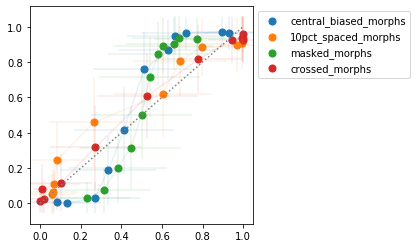

In [377]:
e = '10pct_spaced_morphs' # 
e = 'central_biased_morphs'

M = df_model

plt.figure(figsize=[4, 4])
for e in M.experiment.unique(): 
    y = df[(df.experiment==e) & (df.group=='CON') & (df.day<=1) ].groupby('percent')
    x = M[(M.experiment==e)].groupby('percent')
    plt.scatter( y= y.mean().choice.values, x = x.mean().choice.values, label=e, s=50)
    plt.errorbar(x=x.mean().choice.values, y=y.mean().choice.values, 
                 xerr=x.std().choice.values/2, yerr=y.std().choice.values/2, 
                 alpha=.1)
plt.plot([0, 1], [0, 1], color='grey', linestyle=':', alpha=1)
plt.legend(bbox_to_anchor=[1,1])
plt.xlim(-.05, 1.05)

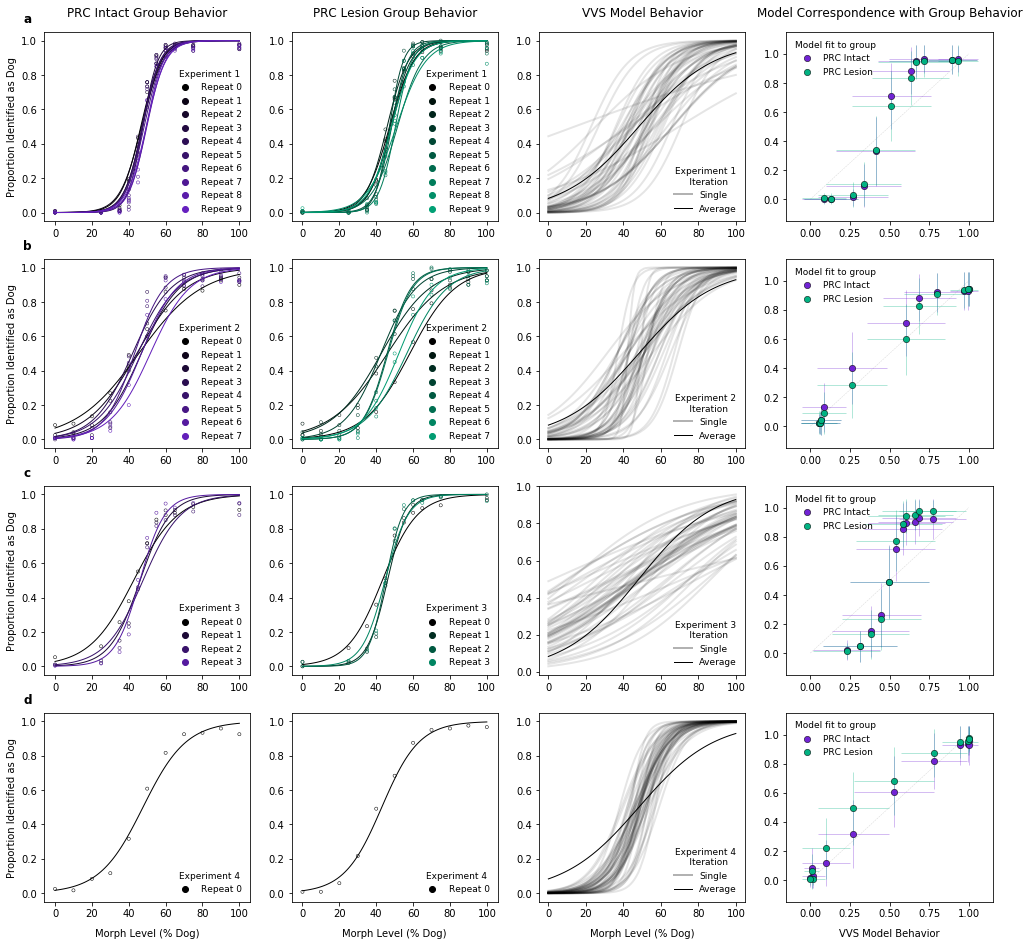

In [372]:
plt.figure(figsize=[17, 16])

show_experimental_performance(df, df_model)

#plt.savefig('results/FIGURE1.pdf', bbox_inches = "tight", format='pdf') 

In [38]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# def show_values(grid, ax, th=.8): 
#     for (j,i),label in np.ndenumerate(grid):
#         #if j<=i: 
#         ax.text(i, 
#                 j, 
#                 np.round(label,2) ,
#                 ha='center',
#                 va='center', 
#                 size=9, 
#                 #fontweight='bold',
#                 color=['black','white'][1*(label<th)])
#     imin = -.5
#     imax = .5+j
    
#     plt.xticks(np.arange(0,j+1), np.arange(0,j+1))
#     plt.yticks(np.arange(0, j+1,), np.arange(0,j+1))
#     plt.ylim(imax, imin)
#     plt.xlim(imin, imax)
    
#     i_color = 'white'
#     i_width=2

#     if j<4:
#         plt.xlabel('GROUP')
#     else: 
#         plt.xlabel("SUBJECT")

# resolution = 'subject'
# target = 'image'
# measure = 'r2'

# image_reliability = get_reliability_matrix(df_reliability, resolution=resolution, target=target,measure=measure)

# plt.figure(figsize=[13, 4])
# iplot=1

# for e in reliability_experiments: 

#     ax = plt.subplot(1, 3, iplot); iplot+=1
#     mat = image_reliability[e]
#     IMSHOW = plt.imshow( mat , clim=[-.01, 1.01], cmap='inferno') 
#     show_values(mat, ax)
#     plt.title('%s -- %s'%(e, target), y=1.05)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     plt.colorbar(IMSHOW, cax=cax, ticks=[0, 1]); 


# resolution = 'subject'
# target = 'percent'
# measure = 'r2'

# image_reliability = get_reliability_matrix(df_reliability, resolution=resolution, target=target,measure=measure)

# plt.figure(figsize=[13, 4])
# iplot=1

# for e in reliability_experiments: 

#     ax = plt.subplot(1, 3, iplot); iplot+=1
#     mat = image_reliability[e]
#     IMSHOW = plt.imshow( mat , clim=[-.01, 1.01], cmap='inferno') 
#     show_values(mat, ax)
#     plt.title('%s -- %s'%(e, target), y=1.05)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     plt.colorbar(IMSHOW, cax=cax, ticks=[0, 1]); 

# for e in reliability_experiments[0:2]:
#     print('\n', e, '\n')
#     print('median split-half within subject reliability %.02f'%
#           np.median(np.diagonal(image_reliability[e])))
#     print('---', np.diagonal(image_reliability[e] ))
#     print('median split-half between subject reliability %.02f'%
#           np.median([image_reliability[e][i,j] for i in range(6) for j in range(6) if i!=j]))

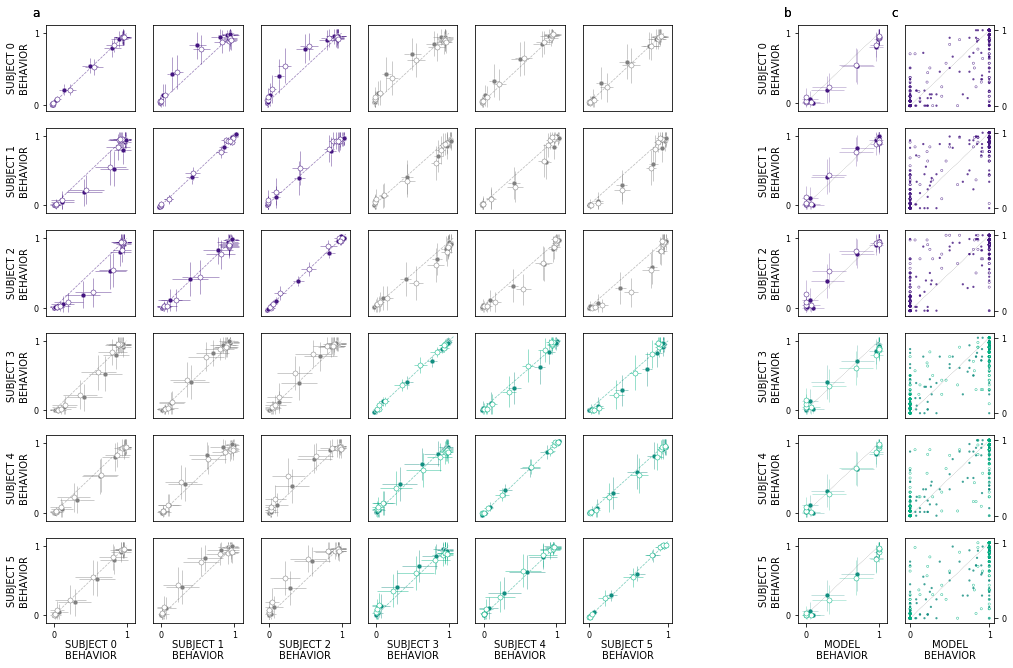

In [149]:
def model_subject_correspondence_TEST(df, df_r, df_m1, resolution='subject', target='image'): 

    def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
        return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

    resolution = 'subject'
    target = 'image'
    TARGET = 'percent'
    df_r = df_reliability
    elements = list( sort(df[resolution].unique()) )
    MATRIX = np.zeros([len(elements), len(elements)])
    VECTOR = [] 
    ncols = len(elements)+3
    nrows = len(elements)
    pointsize = 5
    ticksize  = 8 
    labelsize = 10
    onalpha   = .8
    offalpha  = .3
    linewidth = .5
    maxp = 101 
    minp = -1 

    LWIDTH=.5
    POINTSIZE = 25
    colorscheme = {'central_biased_morphs': {'CON':'#441580',       
                                             'PRC':'#128e80', 
                                             'model':'black'}, 
                   '10pct_spaced_morphs': {'CON':'#441580',       
                                           'PRC':'#01b282', 
                                           'model':'grey'}}

    for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

        iplot = 1         
        ae = df[(df.experiment==e)]
        aer = df_r[(df_r.experiment==e)]
        m1e = df_m1[(df_m1.experiment==e)]
        #m2e = df_m2[(df_m2.experiment==e)]

        for m in elements: 

            x = ae[ae[resolution]==m].groupby(target)
            X = ae[ae[resolution]==m].groupby(TARGET)

            for n in elements: 


                if m == n: 
                    nits = 2
                    maer = aer[aer[resolution]==m]
                    x = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target])
                    y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target])

                    Y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([TARGET])
                    X = maer[(maer.split==1)&(maer.iteration<nits)].groupby([TARGET])
                    alpha=onalpha
                else: 
                    y = ae[ae[resolution]==n].groupby([target])
                    Y = ae[ae[resolution]==n].groupby([TARGET]) 
                    alpha=offalpha

                ax = plt.subplot(nrows, ncols, iplot)
                plt.xticks([]); 
                plt.yticks([]); 

                if n == elements[0]: 
                    plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, 
                               fontsize=labelsize)
                    plt.yticks([0, 1], [0, 1], fontsize=ticksize)

                if m == elements[-1]: 
                    plt.xlabel([n, 'SUBJECT %s\nBEHAVIOR'%n][resolution=='subject'], labelpad=0,
                               fontsize=labelsize)
                    plt.xticks([0, 1], [0, 1], fontsize=ticksize)

                if (m==0)&(n==0):  
                    plt.text(-.15, 1.1, 'a', fontsize=12, transform=ax.transAxes,)



                if   (n in [0,1,2])&(m in [0,1,2]): color=colorscheme[e]['CON']
                elif (n in [3,4,5])&(m in [3,4,5]):color=colorscheme[e]['PRC']
                elif (n in [6,7,8])&(m in [6,7,8]): color=colorscheme[e]['TE']
                else: 
                    color='grey'
         
               # x = bound(x, MAX=max(y), SCALE=max(y))

#                 plt.scatter(x=x.mean().choice.values ,
#                             y=y.mean().choice.values , 
#                             alpha=alpha, 
#                             s=pointsize,
#                             linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
#                             facecolor=[color, ''][e=='10pct_spaced_morphs'], 
#                             edgecolor=['', color][e=='10pct_spaced_morphs'])

                plt.scatter(x=X.mean().choice.values , 
                            y=Y.mean().choice.values , 
                            alpha=1, 
                            s=POINTSIZE,
                            linewidth=LWIDTH, 
                            facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
                            edgecolor=['white', color][e=='10pct_spaced_morphs'])
                
                EB = plt.errorbar(
                    x=X.mean().choice.values, 
                    y=Y.mean().choice.values, 
                    xerr=(X.std().choice.values)/2, 
                    yerr=(Y.std().choice.values)/2,
                    color=color, 
                    linestyle='', 
                    alpha=.8, 
                    elinewidth=.5, 
                    zorder=-1) 

                
                plt.plot([0, 1], [0, 1], linestyle='--', color=color, alpha=.3, zorder=-2, linewidth=.7)
                MATRIX[m, n] = r2_score(y.mean().choice.values, x.mean().choice.values)
                iplot+=1
                

            if   (m in [0,1,2]): color=colorscheme[e]['CON']
            elif (m in [3,4,5]): color=colorscheme[e]['PRC']

            iplot+=1
#             nits = 2
#             maer = aer[aer[resolution]==m]
#             x_split = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#             y_split = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#             X_SPLIT = maer[(maer.split==1)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
#             Y_SPLIT = maer[(maer.split==2)&(maer.iteration<nits)].groupby([TARGET]).mean().choice.values 
#             if m == 0:
#                 plt.scatter([], [], alpha=1, s=POINTSIZE,
#                             linewidth=LWIDTH, 
#                             facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
#                             edgecolor=['white', color][e=='10pct_spaced_morphs'])
                
            
            #######  PERCENT
            ax = plt.subplot(nrows, ncols, iplot)
            plt.xticks([]); plt.yticks([]); 
            plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, fontsize=labelsize)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)

            
            Y_TARGET = ae[ae[resolution]==m].groupby(TARGET)
            X_MODEL = m1e.groupby([TARGET])

            plt.scatter(x=X_MODEL.mean().choice.values, 
                        y=Y_TARGET.mean().choice.values, 
                        alpha=1, 
                        s=POINTSIZE, #-20,
                        linewidth=LWIDTH, 
                        facecolor=[color, 'white'][e=='10pct_spaced_morphs'], 
                        edgecolor=['white', color][e=='10pct_spaced_morphs'])

            EB = plt.errorbar(
                x=X_MODEL.mean().choice.values, 
                y=Y_TARGET.mean().choice.values, 
                xerr=(X_MODEL.std().choice.values)/2, 
                yerr=(Y_TARGET.std().choice.values)/2,
                color=color, 
                linestyle='', 
                alpha=.5, 
                elinewidth=.5, 
                zorder=-1) 

            [EB[-1][i].set_linestyle('-') for i in [0, 1]]
            plt.xticks([]); 
            plt.yticks([]);         
            if m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            if (m==0): 
                plt.text(-.15, 1.1, 'b', fontsize=12, transform=ax.transAxes,)
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.5, zorder=-2, linewidth=.5)
            iplot+=1
       
            ### IMAGE LEVEL VISUALIZATION
            ax = plt.subplot(nrows, ncols, iplot)
            x_model = m1e.groupby([target]).mean().choice.values
            y_target = ae[ae[resolution]==m].groupby(target).mean().choice.values
            
            
            VECTOR.append(r2_score(Y_TARGET.mean().choice.values, X_MODEL.mean().choice.values))
            plt.scatter(x=x_model, y=y_target, 
                        alpha=onalpha, 
                        s=pointsize, 
                        linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                        facecolor=[color, ''][e=='10pct_spaced_morphs'], 
                        edgecolor=['', color][e=='10pct_spaced_morphs'])
            
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            plt.yticks([0, 1], [0, 1], fontsize=ticksize)
            plt.plot([0, 1], [0, 1], linestyle=':', color='grey', alpha=.5, zorder=-2, linewidth=.5)
            if (m==0): 
                plt.text(-.15, 1.1, 'c', fontsize=12, transform=ax.transAxes,)
                plt.xticks([], [])
            elif m == elements[-1]: 
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)
                plt.xlabel('MODEL\nBEHAVIOR', labelpad=0, fontsize=labelsize)
            else: 
                plt.xticks([], [])
            iplot+=1
            
    return MATRIX, np.array(VECTOR)

plt.figure(figsize=[17, 11])            
MATRIX, VECTOR = model_subject_correspondence_TEST(df, df_reliability, df_m1, resolution='subject', target='image')
plt.savefig('./results/FIGURE2_PERCENTONLY.pdf', bbox_inches = "tight", format='pdf')

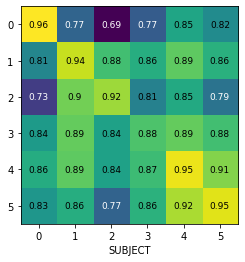

In [150]:
ax = plt.subplot(111) #(figsize=[4,4])
plt.imshow( MATRIX ) 
show_values(MATRIX, ax)

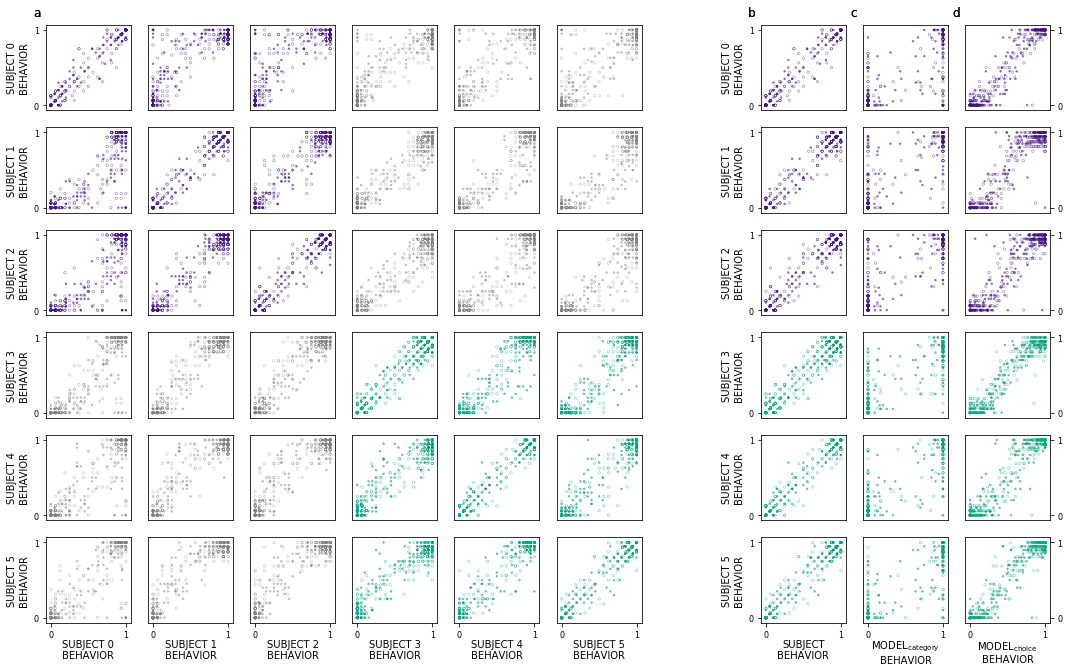

In [62]:
# # def model_subject_correspondence(df, df_r, df_m1, df_m2, resolution='subject', target='image'): 

# plt.figure(figsize=[18, 11])
# def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
#     return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

# resolution = 'subject'
# target = 'image'
# df_r = df_reliability
# elements = list( sort(df[resolution].unique()) )
# matrix = np.zeros([len(elements), len(elements)])
# ncols = len(elements)+4
# nrows = len(elements)
# pointsize = 6
# ticksize  = 8 
# labelsize = 10
# onalpha   = .6
# offalpha  = .5
# linewidth = .5
# maxp = 101 
# minp = -1 

# colorscheme = {'central_biased_morphs': {'CON':'#441580',       
#                                          'PRC':'#128e80', 
#                                          'model':'black'}, 
#                '10pct_spaced_morphs': {'CON':'#441580',       
#                                        'PRC':'#01b282', 
#                                        'model':'grey'}}

# for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

#     iplot = 1         
#     ae = df[(df.experiment==e)]
#     aer = df_r[(df_r.experiment==e)]
#     m1e = df_m1[(df_m1.experiment==e)]
#     m2e = df_m2[(df_m2.experiment==e)]

#     for m in elements: 

#         x = ae[ae[resolution]==m].groupby(target).mean().choice.values

#         for n in elements: 


#             if m == n: 
#                 nits = 2
#                 maer = aer[aer[resolution]==m]
#                 x = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#                 y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#             else: 
#                 y = ae[ae[resolution]==n].groupby([target]).mean().choice.values 

#             ax = plt.subplot(nrows, ncols, iplot)
#             plt.xticks([]); 
#             plt.yticks([]); 

#             if n == elements[0]: 
#                 plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, 
#                            fontsize=labelsize)
#                 plt.yticks([0, 1], [0, 1], fontsize=ticksize)

#             if m == elements[-1]: 
#                 plt.xlabel([n, 'SUBJECT %s\nBEHAVIOR'%n][resolution=='subject'], labelpad=0,
#                            fontsize=labelsize)
#                 plt.xticks([0, 1], [0, 1], fontsize=ticksize)

#             if (m==0)&(n==0):  
#                 plt.text(-.15, 1.1, 'a', fontsize=12, transform=ax.transAxes,)


#             alpha=onalpha
#             if   (n in [0,1,2])&(m in [0,1,2]): color=colorscheme[e]['CON']
#             elif (n in [3,4,5])&(m in [3,4,5]):color=colorscheme[e]['PRC']
#             elif (n in [6,7,8])&(m in [6,7,8]): color=colorscheme[e]['TE']
#             else: 
#                 color='grey'
#                 alpha=offalpha

#             x = bound(x, MAX=max(y), SCALE=max(y))

#             plt.scatter(x=x, y=y, 
#                         alpha=alpha, 
#                         s=pointsize,
#                     linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
#                     facecolor=[color, ''][e=='10pct_spaced_morphs'], 
#                     edgecolor=['', color][e=='10pct_spaced_morphs'])


#             matrix[m, n] = r2_score(y, x)

#             iplot+=1

            
            
#         if   (m in [0,1,2]): color=colorscheme[e]['CON']
#         elif (m in [3,4,5]): color=colorscheme[e]['PRC']
            
#         iplot+=1
#         nits = 2
#         maer = aer[aer[resolution]==m]
#         x_split = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#         y_split = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
#         ax = plt.subplot(nrows, ncols, iplot)
#         plt.xticks([]); 
#         plt.yticks([]); 
#         plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, fontsize=labelsize)
#         plt.yticks([0, 1], [0, 1], fontsize=ticksize)
#         plt.scatter(x=x_split, y=y_split, 
#                         alpha=onalpha, 
#                         s=pointsize,
#                     linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
#                     facecolor=[color, ''][e=='10pct_spaced_morphs'], 
#                     edgecolor=['', color][e=='10pct_spaced_morphs'])
#         if (m==0): 
#             plt.text(-.15, 1.1, 'b', fontsize=12, transform=ax.transAxes,)
#         if (m==5): 
#             plt.xticks([0, 1], [0, 1], fontsize=ticksize)
#             plt.xlabel('SUBJECT\nBEHAVIOR',  labelpad=0, fontsize=labelsize)
        
#         iplot+=1
        
#         #
#         y_target = ae[ae[resolution]==m].groupby(target).mean().choice.values
        
#         # MODEL 0 
#         ax = plt.subplot(nrows, ncols, iplot) #ax.set_facecolor(color) #(1.0, 0.47, 0.42))
#         x_model = m1e.groupby([target]).mean().choice.values
#         plt.scatter(x=x_model, y=y_target, 
#                     alpha=onalpha, 
#                     s=pointsize, 
#                     linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
#                     facecolor=[color, ''][e=='10pct_spaced_morphs'], 
#                     edgecolor=['', color][e=='10pct_spaced_morphs'])
        
#         plt.xticks([]); 
#         plt.yticks([]);         
#         if m == elements[-1]: 
#             plt.xticks([0, 1], [0, 1], fontsize=ticksize)
#             plt.xlabel('MODEL$_{\mathrm{category}}$\nBEHAVIOR', labelpad=0, fontsize=labelsize)
#         if (m==0): 
#             plt.text(-.15, 1.1, 'c', fontsize=12, transform=ax.transAxes,)
#         #plt.legend([], [], title='$R^{2}$=%.02f'%r2_score(x, x_model), loc=2, framealpha=0, fontsize=8)
#         iplot+=1

#         # MODEL 2
#         ax = plt.subplot(nrows, ncols, iplot)
#         x_model = BOUND(m2e[m2e[resolution]==m].groupby([target]).mean().choice.values)
#         plt.scatter(x=x_model, y=y_target, 
#                 alpha=onalpha,
#                 s=pointsize,
#                     linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
#                     facecolor=[color, ''][e=='10pct_spaced_morphs'], 
#                     edgecolor=['', color][e=='10pct_spaced_morphs'])
        
#         plt.xticks([]); 
#         plt.yticks([]); 
#         ax.yaxis.set_label_position("right")
#         ax.yaxis.tick_right()
#         plt.yticks([0, 1], [0, 1], fontsize=ticksize)
#         if m == elements[-1]: 
#             plt.xticks([0, 1], [0, 1], fontsize=ticksize)
#             plt.xlabel('MODEL$_{\mathrm{choice}}$\nBEHAVIOR', labelpad=0, fontsize=labelsize)
#         if (m==0): 
#             plt.text(-.15, 1.1, 'd', fontsize=12, transform=ax.transAxes)
#         #plt.legend([], [], title='$R^{2}$=%.02f'%r2_score(x, x_model), loc=2, framealpha=0, fontsize=8)        
#         iplot+=1

# plt.savefig('./results/FIGURE2_CONSERVATIVE.pdf', bbox_inches = "tight", format='pdf')

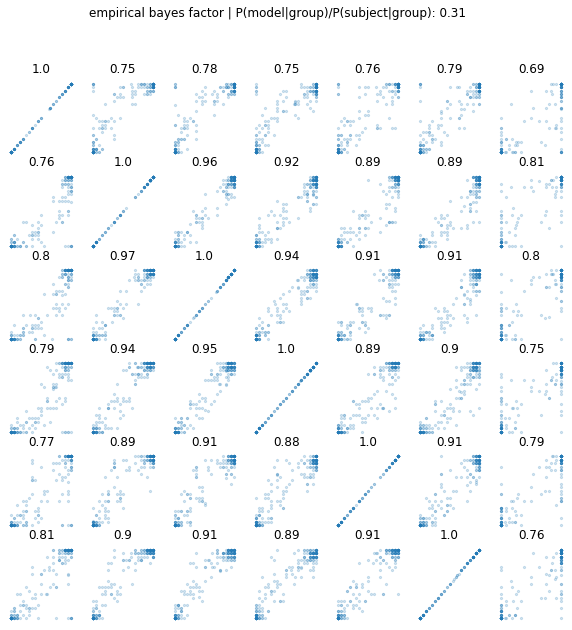

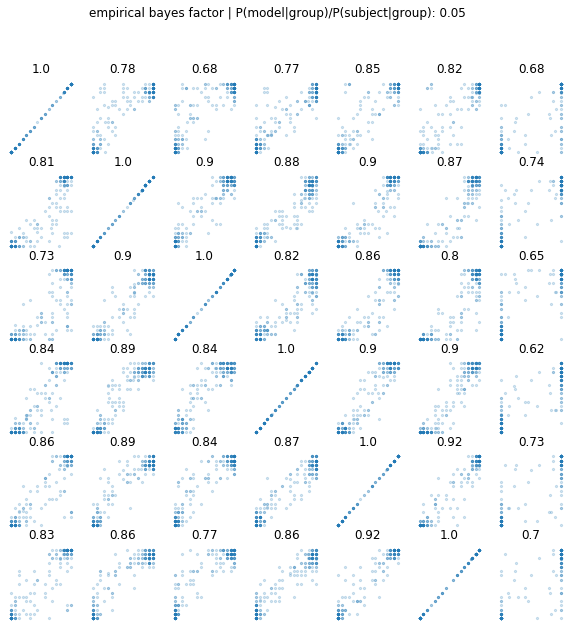

In [1300]:
resolution = 'subject'
target = 'image'
measure = 'r2'
# percent_reliability = get_reliability_matrix(df_reliability, 
#                                              resolution=resolution, 
#                                              target=target,
#                                              measure=measure)

s = 30
a = .2



for e in ['central_biased_morphs', '10pct_spaced_morphs']:
        
    ef = df[df.experiment==e]
    ss = [ef[(ef.subject==i)].groupby(target).mean().choice.values for i in ef.subject.unique()]
    m1 =  df_m1[df_m1.experiment==e].groupby(target).mean().choice.values
   
    if measure=='r': 
        print('!')
    elif measure=='r2': 
        between_ss = [r2_score(ss[i], ss[j]) for i in range(len(ss)) for j in range(len(ss)) if i!=j]
        rs = [r2_score(ss[i], m1) for i in range(len(ss))]

    empirical_bayes = []     
    for s in df.subject.unique(): 
        s_fits = [r2_score(ss[i], ss[s]) for i in range(len(ss)) if i!=s]
        other_between =  [r2_score(ss[i], ss[j]) for i in range(len(ss)) for j in range(len(ss)) if (i!=j)&(i!=s)&(j!=s)]
        rs = [r2_score(ss[i], m1) for i in range(len(ss))]
        pM_bs = max(.000001, np.mean( np.median( rs ) >= np.array( between_ss ) )) 
        pS_bs = max(.000001, np.mean( np.median( s_fits ) >= np.array( other_between ) ))
        empirical_bayes.append( pM_bs / pS_bs) 

    plt.figure(figsize=[10,10])
    iplot=1
    for i in range(len(ss)): 
        for j in range(len(ss)):
            plt.subplot(len(ss), len(ss)+1, iplot)
            plt.scatter(x=ss[i], y=ss[j],  alpha=a, s=s)
            plt.title(r2_score(ss[j], ss[i]).round(2))
            plt.axis('off')
            iplot+=1
        plt.subplot(len(ss), len(ss)+1, iplot)
        plt.scatter(x=m1,y=ss[i],  alpha=a, s=s)
        plt.title(r2_score(ss[i], m1).round(2))
        plt.axis('off')
        iplot+=1
        
    plt.suptitle('empirical bayes factor | P(model|group)/P(subject|group): %.02f'%np.median(empirical_bayes) )


In [19]:
def build_model2(df, n_iterations): 

    def make_column(x, test_df): return np.repeat(x, len(test_df))
                
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', max_iter=2000)}
    
    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'choice'
    model_type = 'linear'
    mask_indices = get_masked_indices()   
    df_model = pandas.DataFrame()

    for i_test in df.experiment.unique():
        
        e_df = df[df.experiment==i_test]

        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]

        for i_iteration in range(n_iterations):

            random_order = np.random.permutation(range(len(X)))
            i_split = int(len(random_order)*(train_test_ratio))

            for i_subject in df.subject.unique(): 

                s_df = e_df[e_df.subject==i_subject]

                train = s_df[ [i in random_order[:i_split] for i in s_df.image_id.values] ] 
                test  = s_df[ [i in random_order[i_split:] for i in s_df.image_id.values] ] 

                train = train.groupby(analysis_level, as_index=False).mean()
                test  = test.groupby(analysis_level, as_index=False).mean()

                x_train = [X[int(i-1)] for i in train.image_id.values]
                x_test  = [X[int(i-1)] for i in test.image_id.values]

                readouts[model_type].fit(x_train, train[target].values)
                model_predictions =  readouts[model_type].predict(x_test)

                # bookkeeping
                i_df = pandas.DataFrame({
                            'group': make_column('model', test), 
                            'subject': make_column(i_subject, test), 
                            'experiment': make_column(i_test, test),
                            'iteration': make_column(i_iteration, test), 
                            'percent': test.percent.values, 
                            'image_id': test.image_id.values, 
                            'image': test.image.values, 
                            'ground_truth': 1 * (test.percent.values >= 50),
                            'analysis_level': make_column(analysis_level, test), 
                            'target': make_column(target, test), 
                            'choice': model_predictions, 
                            'correct': (np.array(model_predictions)>=.5) == (1*(test.percent.values >= 50)), 
                            'y': test[target].values
                            })

                df_model = df_model.append(i_df, ignore_index=True)

    return df_model